# Fits and Data Analysis
---
* Analysing and fitting Data (usage of scipy)
* Linear Regression using Least-Squares
* Visualisation of fits

#### Create a function for fast plotting to rapidly check/visualize some data

In [202]:
import matplotlib.pyplot as plt

# needed only in jupyter and this session ---
# please ignore the following 3 lines
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'DejaVu Sans','size': 20})

def fast_plot(x, y, style=".", xlabel="predictor $x$", ylabel="response $y$"):
    """
    Function for plotting y vs x as points
    Args:
    optional arguments are the axis labels
    Returns:
    Plot of y vs x
    """
    
    fig, ax = plt.subplots()
    ax.plot(x, y, style)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.show()

## Basics of fitting

Lets generate a linear relationship with some noise and fit a function to it

In [150]:
import numpy as np

# create a random linear dataset
N = 100
x = np.linspace(0, 1, N)
randnr = np.random.rand(N)
y = - x + 2.0 + (randnr*0.5)

Now lets check that the created linear relationship has indeed a decaying behaviour

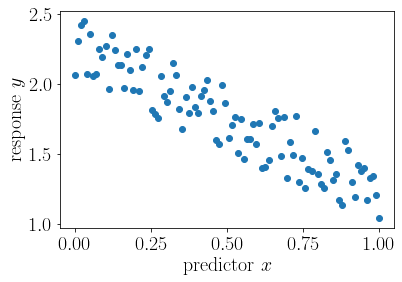

In [153]:
fast_plot(x, y, "o")

### Fitting the data

Here we generated both the x and the y values. Usually when fitting the latter represent the dependent variable which we would like to fit.

The first step is to understand what function we would like to fit to y. In this case it a linear slope. We thus create such a function with some unknown coefficients $a$ and $c$: $f(x) = a x + c$

In [154]:
def fitting_lin_slope(x, a, c):
    return a * x + c

Now we load an additional library that is built upon `numpy` and is specifically designed for scientific computing. We don't load the entire library, but only the fitting function we need

In [155]:
from scipy.optimize import curve_fit

`curve_fit()` is a function that, as the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) tells us, uses "non-linear least squares to fit a function, f, to data".

In other words: we have to give `curve_fit` a function (which we assume will fit our data), the independet values of x and the dependent values of y.

The output will be twofold: 
* on one side we have an array with the optimal values for the coefficients of our function (in this case $a$ and $c$)
* on the other we get a matrix with the covariance values of the optimized coefficients, from which we can the compute the standard deviation taking the square root of the diagonal elements.


In [156]:
# optimize function coefficients | test bounds=([-1,0], [0,2])
opt_vals, cov_coeff = curve_fit(fitting_lin_slope, x, y)

print("optimal a = {}\noptimal c = {}\n\nstd of a = {}\nstd of c = {}".
      format(opt_vals[0], opt_vals[1], *np.sqrt(np.diag(cov_coeff))))

optimal a = -1.0710975976277681
optimal c = 2.275654346249434

std of a = 0.04933206494866907
std of c = 0.028553714313043155


as we can see the optimal $a$ is indeed close to $-1$ and the optimal $c$ is close to $2.25$ as we defined them in our generating relationship

__note__: for a list `l = [0,1,2,3,4, ... , n]` writing `*l` is equivalent to writing `l[0], l[1], l[2], ... ,l[n]`. We are going to use this notation more often in the following

---
Now lets visualize the data with its fit. To do so it is now very convenient that we defined the fitting function, since we can now use this to generate the fitting slope

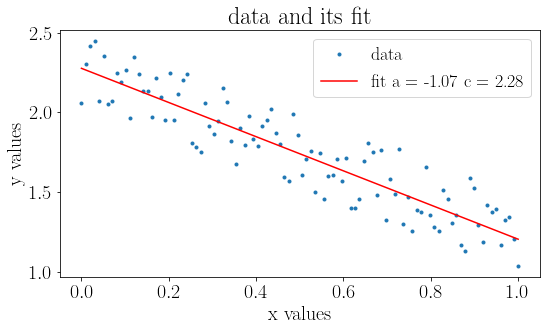

In [157]:
fig, ax = plt.subplots(figsize=(8,5), tight_layout = True)

text_label_fit = "fit a = {:.3} c = {:.3}".format(*opt_vals)

ax.plot(x, y, ".", label="data")
ax.plot(x, fitting_lin_slope(x, *opt_vals), "r-", label = text_label_fit)

ax.legend(fontsize=18)

ax.set_xlabel("x values")
ax.set_ylabel("y values")

ax.set_title("data and its fit")

fig.show()

## Gaussian fit to distribution

---

Now lets see another very common fit: the Gaussian fit.

For every distribution you find, you might want to fit a Gaussian distribution to some data

From the a [machine learning repository](https://archive.ics.uci.edu/ml/index.php) we can take the data about forest fires. (as you see the `read_csv()` method of pandas is able to get data als from online links)

In [158]:
import pandas as pd

fires = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv', 
                   index_col=0)

fires

,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,,,,,,,,,,,,
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16


This dataframe now contains a lot of interesting data (and a little bit more than before with the populations and the brain sizes) to be analised.

As we will see, the temperature is has a distribution of the data that mostly resembles a Gaussian, we therefore want to fit this distribution.

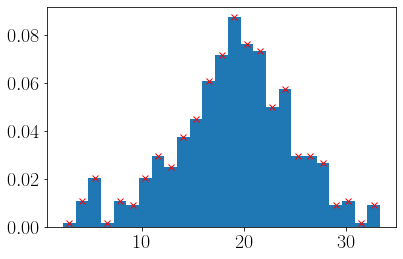

In [72]:
# save temperature data to one array
temps = fires.temp

binnr = 25

# check with a plot the histogram and save the histogram values
fig, ax = plt.subplots(1,1, tight_layout = True)

vals, binedge, handle = ax.hist(temps, bins=binnr, density=True)

# to overcome wrong positioning of the bins, compute the width of one bin and subtract half of it it to the edges
# bin_width = binedge[1] - binedge[0]

# - bin_width/2
bincenter = binedge[1:]

# plot maxima of the values
ax.plot(bincenter, vals, "rx")

fig.show()

here we rapidly checked the values of the temperature as a histogram with 25 bins and saved the variables of the histogram and the bin edges to two variables.

This could have been done also separately with the according [numpy histogram function](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html#numpy.histogram).

__note__: that the output of the `hist()` function are the values of the histogram and the binedges, meaning an array of the length $binnr + 1$. We thus have to compute the bincenters with the width of the bins.

Now we can create a function for the Gaussian distribution (refer e.g. to the [wikipedia page](https://en.wikipedia.org/wiki/Gaussian_function))

In [67]:
def gaussian(x, mu, sigma):
    return (1/(sigma*np.sqrt(2*np.pi))*np.exp(- ((x - mu)**2)/(2*sigma**2) ))

In [125]:
# fit the gaussian to the values of the histogram
opt_vals, cov_coeff = curve_fit(gaussian, bincenter, vals)

print("optimal expected value mu: {}\noptimal standar deviation sigma: {}".format(*opt_vals))

optimal expected value mu: 19.45990838629157
optimal standar deviation sigma: 5.259990630777888


In [99]:
gauss_fit

array([0.0005097 , 0.00104727, 0.00203473, 0.00373823, 0.00649432,
       0.01066866, 0.01657273, 0.02434372, 0.03381335, 0.04441176,
       0.05515897, 0.06478027, 0.07194123, 0.07554773, 0.07501937,
       0.07044236, 0.06254647, 0.05251461, 0.04169327, 0.03130115,
       0.02222097, 0.01491675, 0.00946878, 0.00568358, 0.00322596])

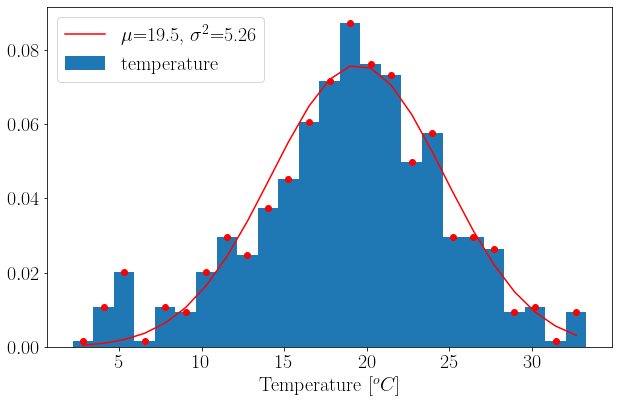

In [147]:
# plot everything

mu, sigma = opt_vals[0], opt_vals[1]
gauss_fit = gaussian(bincenter, *opt_vals)
max_gauss = max(gauss_fit)

fig, ax = plt.subplots(1,1, figsize=(9,6), tight_layout=True)

ax.hist(temps, bins=binnr, density=True, label="temperature")
ax.plot(bincenter, vals, "ro")

label_text="$\mu$={:.3}, $\sigma^2$={:.3}".format(*opt_vals)
ax.plot(bincenter, gauss_fit, 'r-', label=label_text)

ax.set_xlabel("Temperature [$^oC$]")
ax.legend()

# # find value for half max gauss
# half_max_idx = np.abs(gauss_fit - max_gauss/2).argmin()
# print(bincenter[half_max_idx])
# starting_bin = bincenter[half_max_idx]
# if starting_bin < mu:
#     xmin, xmax = starting_bin, starting_bin + 2*sigma
# else:
#     xmax, xmin = starting_bin, starting_bin - 2*sigma

# # plot mu and sigma
# ax.vlines(x=mu, color="grey", linestyle="--", ymin=0, ymax=max_gauss)
# ax.hlines(y=max_gauss/2, xmin=xmin, xmax=xmax, color="grey", linestyle="--")

fig.show()

## Systematic data Analysis

### Steps on Data
Some things are often shared among several data sets this is why it is useful to consider almost always and to add them to a function (or even to an existing class) with this function we can collect information about any given variable and print it out as well as do some basic visualisation of histograms and cumulative distribution functions

### Empirical Mean

$$\bar{x} = \frac{1}{N}\sum_i{x_i}$$

$$\bar{y} = \frac{1}{N}\sum_i{y_i}$$

### Empirical Variance
$$ \mathrm{Var} = \frac{1}{n-1} \sum_{i=1}^{n}{ \left( y_i - \bar{y} \right)^2  } $$

### Empirical Standard Deviation
$$ S = \sqrt{\mathrm{Var}}$$

Notice that standard deviation is expressed in the same units as $y_i$.

In [189]:
def scanVariable(var, varname = 'variable'):        
        #basic
        print("\nMin    = {}".format(np.min(var)))
        print("Max    = {}".format(np.max(var)))
        print("Mean   = {}".format(np.mean(var)))
        print("SD     = {}".format(np.std(var)))
        print("Var    = {}".format(np.std(var)**2))
        print("Median = {}".format(np.median(var)))
        print("Length = {}".format(len(var))) 
        
        #visualize        
        nbins = int(np.sqrt(len(var)))    
        fig1 = plt.figure(figsize = (10,5))         
        col = 'cyan'
        # create histogram
        ax1 = fig1.add_subplot(131)
        ax1.hist(var, bins=nbins, ec='black', color=col)
        
        ax1.set_xlabel(varname)
        ax1.set_ylabel('count')
        ax1.set_title("Original")        
        
        # normalised histogram
        ax1 = fig1.add_subplot(132)
        ax1.hist(var/np.std(var), bins=nbins, ec='black', color=col,density=True)
        ax1.set_xlabel(varname)
        ax1.set_title("Normalized/Density")  
        
        ax1 = fig1.add_subplot(133)
        ax1.hist(var/np.std(var), bins=nbins, ec='black', color=col,density=True,cumulative=True)
        ax1.set_xlabel(varname)
        ax1.set_title("Cumulative")


Min    = 0.4
Max    = 9.4
Mean   = 4.017601547388782
SD     = 1.789919022794071
Var    = 3.2038101081600816
Median = 4.0
Length = 517


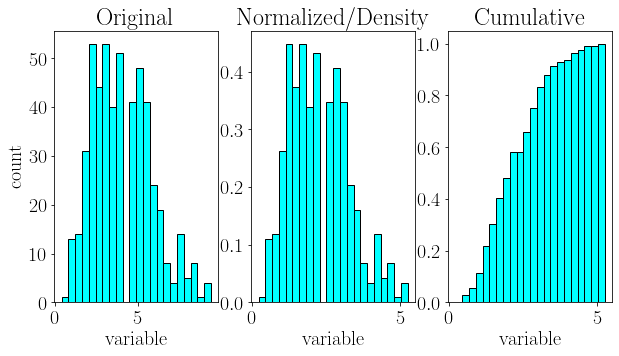

In [258]:
# example
scanVariable(fires["wind"])

### Terminology

- "Predictor" or "independent" variable or "stimulus" (in our case $x$).
- "Dependent" or "response" variable (in our case $y$). 
- "Positive" and "negative" relationship.

Lets get back to the forest fires and look at how other collected data, e.g. the relative humidity RH, compares to the temperature

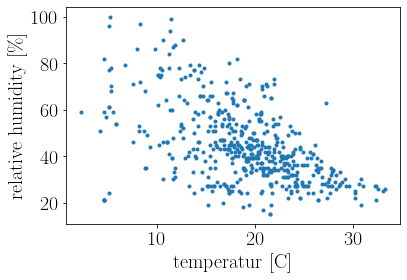

In [206]:
temps = fires["temp"]
RH = fires["RH"]

fast_plot(temps, RH, xlabel="temperatur [C]", ylabel="relative humidity [\%]")


the idea here is to see if the is a relationship in the depicted data or not


Min    = 2.2
Max    = 33.3
Mean   = 18.88916827852998
SD     = 5.801006939598366
Var    = 33.65168151326841
Median = 19.3
Length = 517

Min    = 15
Max    = 100
Mean   = 44.28820116054158
SD     = 16.301680682958068
Var    = 265.7447930891282
Median = 42.0
Length = 517


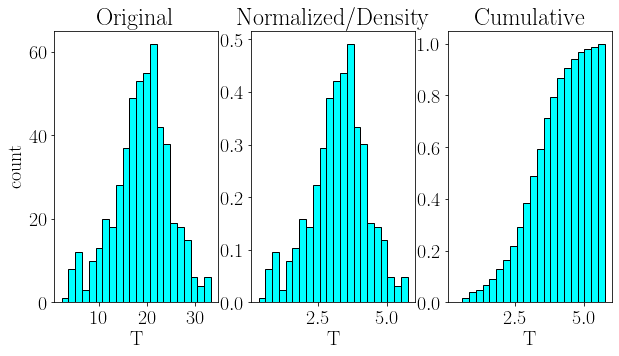

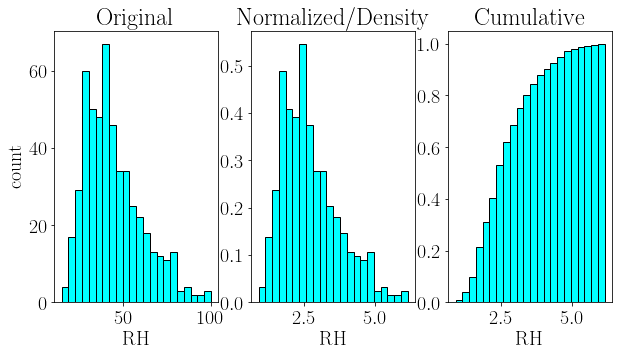

In [193]:
scanVariable(temps, varname="T")
scanVariable(RH, varname="RH")

### Centering

$x_i = x_i-\bar{x}$

$y_i = y_i-\bar{y}$

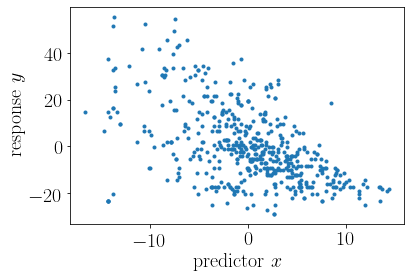

In [242]:
# compute the mean values
temps_mean = sum(temps)/len(temps)
RH_mean = sum(RH)/len(RH)

# center the data
temps = temps - temps_mean
RH = RH - RH_mean

# recompute the mean values
temps_mean = sum(temps)/len(temps)
RH_mean = sum(RH)/len(RH)

fast_plot(temps,RH)

### Normalization/rescaling

This is done to have SD = 1, and mean = 0.

$x_i = \frac{x_i}{SD}$

$y_i = \frac{y_i}{SD}$

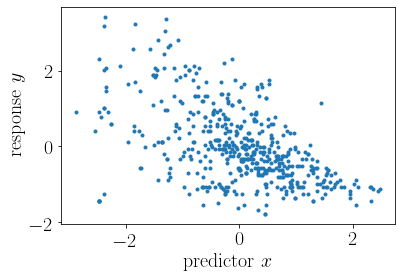

1.0
1.0


In [211]:
# normalise
temps=temps/np.std(temps)
RH=RH/np.std(RH)

# show normalised values
fast_plot(temps,RH)

print(np.std(temps))
print(np.std(RH))

## Linear Regression with Least Squares

---

In the Least-Squares we "Compute least-squares solution to equation Ax = b."
Here we are using the least-square method from [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html).

To do so we take the a Matrix `M` that is composed by the constant and linear entries of the predictor variable (i.e. the independent variable). Since we first assume a linear relationship `y = a + b*x`. In the following A=M is the coefficient matrix

In [244]:
temps = fires["temp"]
RH = fires["RH"]

# matrix of the temperatures in 0-th and 1st order.
M = temps[:, np.newaxis]**[0, 1]
print(M)

[[ 1.   8.2]
 [ 1.  18. ]
 [ 1.  14.6]
 ...
 [ 1.  21.2]
 [ 1.  25.6]
 [ 1.  11.8]]


now we are ready to apply the least-square method to our relative humidity RH. The main result from the optimisation is stored in the variable `coeff` that is composed by the optimised coefficients $a$ and $b$ of $y = a + b\cdot x$.

So the first entry of `coeff` will be the y-axis intersection and the second one will be the slope

linear relationship
y-axis intersection: 72.2827841238002
and slope: -1.482044235641552


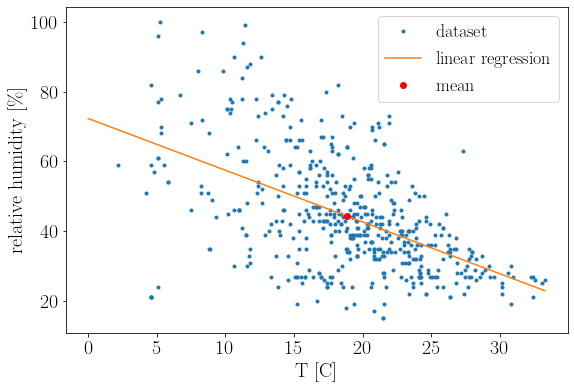

In [255]:
# import the least-square method
from scipy.linalg import lstsq

# apply the least-square
coeff, res, rnk, s = lstsq(M, RH)

# print some information
print("linear relationship\ny-axis intersection: {}\nand slope: {}".format(*coeff))

# compute the mean values
temps_mean = sum(temps)/len(temps)
RH_mean = sum(RH)/len(RH)

# create variables for plotting the linear regression
xx = np.linspace(0, max(temps), 100)
yy = coeff[0] + coeff[1]*xx**1

fig, ax = plt.subplots(1,1, figsize=(9,6))

ax.plot(temps,RH, ".", label="dataset")
ax.plot(xx,yy, label='linear regression')
ax.plot(temps_mean, RH_mean, "ro", label="mean")


# plot cosmetics
ax.legend(fontsize=18)
ax.set_xlabel("T [C]")
ax.set_ylabel("relative humidity [\%]")


fig.show()

## Assignments
---
* Create an exponentially decaying relationship with some noise and fit it using first a linear slope function and then an exponential function. Compare and comment on the covariance/standar deviation.
* Create a function for automatising the Gaussian fit and eventually add it to a class. Test it on different variables of the forest fires data
* Use the least-square method of scipy to test the relative humidity vs temperature plot for a second order relationship. Find a different pair of dependent variables of the set to analyse and do a linear regression on them. Can you find any interesting relations when looking at the months?
* understand how the [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) method of sklearn works and try to apply it to the "temperature-relative humidity" data